In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

from dataclasses import dataclass

2024-05-13 00:11:28.183874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 00:11:28.183973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 00:11:28.316457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED_VALUE = 42
DIR = "."
IMAGE_DIR = os.path.join(DIR, "visuals")
MODEL_DIR = os.path.join(DIR, "models")

if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    
plt.rcParams['figure.facecolor'] = 'beige'
plt.rcParams['axes.titlecolor'] = 'seagreen'
plt.rcParams['axes.titlesize'] = 12

np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
train_set, valid_set, test_set = tfds.load('malaria', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                           as_supervised=True)
info = tfds.builder("malaria").info

In [38]:
def save_fig(name, fig_extension="png", tight_layout=True, resolution=300):
    path = os.path.join(IMAGE_DIR, name + '.' + fig_extension)
    print(f"Saving figure {name}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def save_model(model, name:str=None):
    model_path = os.path.join(MODEL_DIR, name)
    if not os.path.exists(model_path):
        print(f"Saving model {name}")
        model.save(model_path)
    else:
        print("Model with that name already exists.")

Saving figure smear


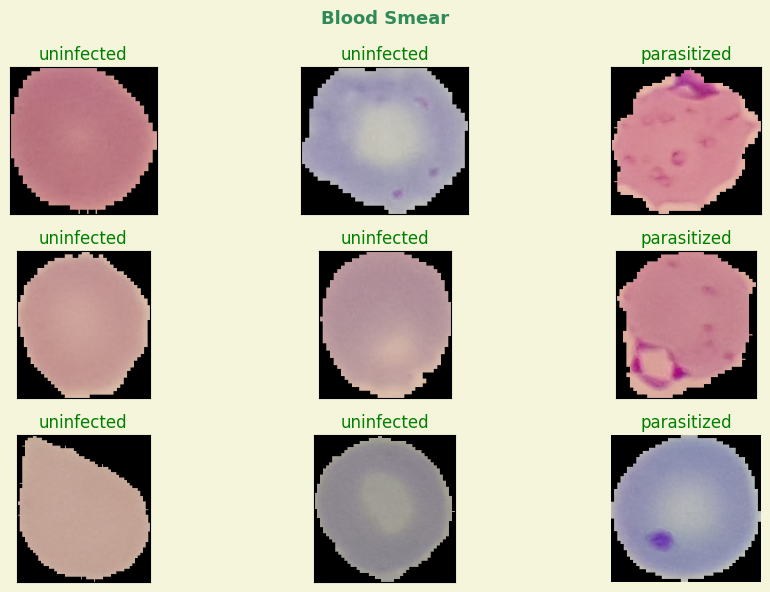

In [5]:
fig = plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_set.take(9)):
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(image)
    ax.set_xticks([]);ax.set_yticks([])
    ax.set_title(f"{info.features['label'].int2str(label)}", color='g')
plt.suptitle("Blood Smear", weight='bold', color='seagreen', size=13)
plt.axis('off')
plt.grid(True)
save_fig("smear")
plt.show()

### Data/Training Configuration.

In [6]:
@dataclass(frozen=True)
class DataConfig():
    IMG_HEIGHT:    int = 224
    IMG_WIDTH:    int = 224
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainConfig:
    BATCH_SIZE:       int = 32
    EPOCHS:           int = 31
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int = 8
    BUFFER_SIZE:      int = 1000

- Preprocessing.

In [56]:
def preprocess_dataset(dataset: tf.data.Dataset, shuffle_dataset=False, augment=False, hsv=False):
    def preprocess_image(image, label):
        image = tf.keras.applications.vgg16.preprocess_input(image)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH))
        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        if hsv:
            image = tf.image.random_hue(image, 0.08)
            image = tf.image.random_saturation(image, 0.6, 1.6)
            image = tf.image.random_brightness(image, 0.05)
            image = tf.image.random_contrast(image, 0.7, 1.3)
        return image, label
    
    ds = dataset.cache()
    ds = ds.map(preprocess_image)
    ds = ds.batch(TrainConfig.BATCH_SIZE)
    if shuffle_dataset:
        ds = ds.shuffle(buffer_size=TrainConfig.BUFFER_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

In [57]:
train_ds = preprocess_dataset(train_set, shuffle_dataset=True, augment=False, hsv=False)
valid_ds = preprocess_dataset(valid_set, augment=False, hsv=False)
test_ds = preprocess_dataset(valid_set, augment=False, hsv=False)

- Visuals from the test dataset.

Saving figure cells_preprocessed


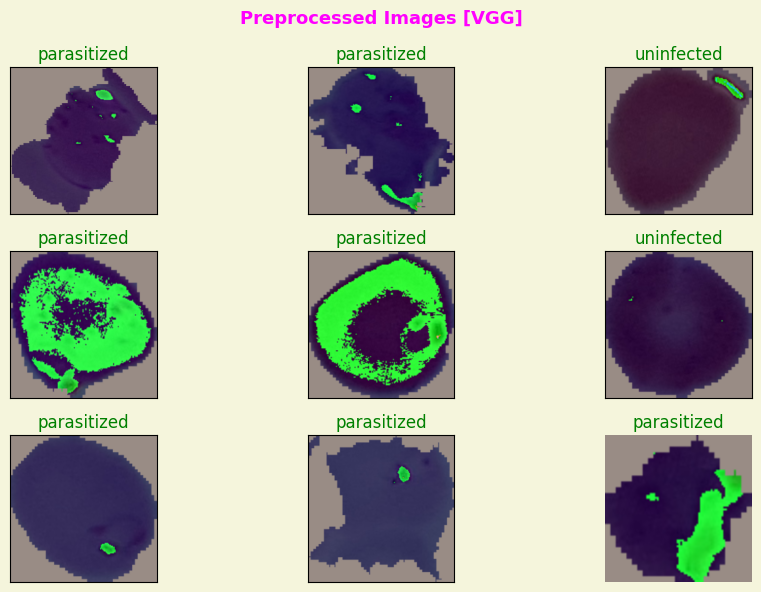

In [58]:
fig = plt.figure(figsize=(10, 6))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy())
        ax.set_xticks([]);ax.set_yticks([])
        ax.set_title(info.features['label'].int2str(labels_batch[i].numpy()), color='g')
plt.suptitle("Preprocessed Images [VGG]", weight='bold', color='magenta', size=13)
plt.axis('off')
plt.grid(True)
save_fig("cells_preprocessed")
plt.show()

### Modeling with VGG16.

In [10]:
input_shape = (DataConfig.IMG_HEIGHT, DataConfig.IMG_WIDTH, DataConfig.NUM_CHANNELS)

vgg = tf.keras.applications.vgg16.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
vgg.trainable = True

layers_fine_tune = TrainConfig.LAYERS_FINE_TUNE
num_layers = len(vgg.layers)

for vgg_layer in vgg.layers[:num_layers - layers_fine_tune]:
    print(f"Freezing Layer: {vgg_layer}")
    vgg_layer.trainable = False
    
print("\nConfigured to train the last", layers_fine_tune, "conv layers.\n")
vgg.summary()

Freezing Layer: <InputLayer name=input_layer, built=True>
Freezing Layer: <Conv2D name=block1_conv1, built=True>
Freezing Layer: <Conv2D name=block1_conv2, built=True>
Freezing Layer: <MaxPooling2D name=block1_pool, built=True>
Freezing Layer: <Conv2D name=block2_conv1, built=True>
Freezing Layer: <Conv2D name=block2_conv2, built=True>
Freezing Layer: <MaxPooling2D name=block2_pool, built=True>
Freezing Layer: <Conv2D name=block3_conv1, built=True>
Freezing Layer: <Conv2D name=block3_conv2, built=True>
Freezing Layer: <Conv2D name=block3_conv3, built=True>
Freezing Layer: <MaxPooling2D name=block3_pool, built=True>

Configured to train the last 8 conv layers.



Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

- Adding the classifier.

In [12]:
inputs = tf.keras.Input(shape=input_shape)

x = vgg(inputs)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(TrainConfig.DROPOUT)(x)

output = layers.Dense(1, activation='sigmoid')(x)

model_vgg  = Model(inputs, output)

model_vgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 25,825,281 (98.52 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

### Compiling and Training.

In [13]:
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainConfig.LEARNING_RATE),
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                 metrics=["accuracy"])

In [23]:
training_history = model_vgg.fit(train_ds, 
                                epochs=TrainConfig.EPOCHS,
                                validation_data=valid_ds)

Epoch 1/31


I0000 00:00:1715553466.031164     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715553466.055417     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


371/689 ━━━━━━━━━━━━━━━━━━━━ 1:03 200ms/step - accuracy: 0.8882 - loss: 0.2893

W0000 00:00:1715553582.310216     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9096 - loss: 0.2445

W0000 00:00:1715553647.251891     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 269s 288ms/step - accuracy: 0.9096 - loss: 0.2444 - val_accuracy: 0.9507 - val_loss: 0.1432
Epoch 2/31


W0000 00:00:1715553664.561072     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9549 - loss: 0.1430 - val_accuracy: 0.9561 - val_loss: 0.1338
Epoch 3/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 217ms/step - accuracy: 0.9584 - loss: 0.1230 - val_accuracy: 0.9525 - val_loss: 0.1392
Epoch 4/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9612 - loss: 0.1157 - val_accuracy: 0.9583 - val_loss: 0.1145
Epoch 5/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9657 - loss: 0.0993 - val_accuracy: 0.9612 - val_loss: 0.1150
Epoch 6/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9690 - loss: 0.0870 - val_accuracy: 0.9568 - val_loss: 0.1297
Epoch 7/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9727 - loss: 0.0791 - val_accuracy: 0.9554 - val_loss: 0.1539
Epoch 8/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 166s 230ms/step - accuracy: 0.9750 - loss: 0.0736 - val_accuracy: 0.9626 - val_loss: 0.1501
Epoch 9/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 156s 216ms/step - accuracy: 0.9763 - loss: 0.06

#### Training Results.

In [17]:
def plot_results(metrics, metric_name=None, title=None, ylabel=None, ylim=None, xlim=None, color=None):
    fig, ax = plt.subplots(figsize=(8, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics]
        metric_name = [metric_name]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.title(title, pad=10.0, weight='bold', color='magenta')

    ax.xaxis.set_major_locator(plt.MultipleLocator(2))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))

    plt.grid(True)
    plt.legend(metric_name)
    save_fig(title)
    plt.show()
    plt.close()

Saving figure Vgg16 Train vs Validation Accuracy


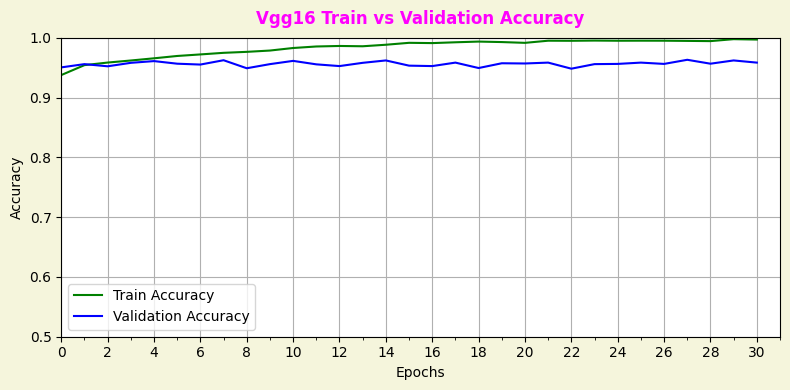

Saving figure Vgg16 Train vs Validation Loss


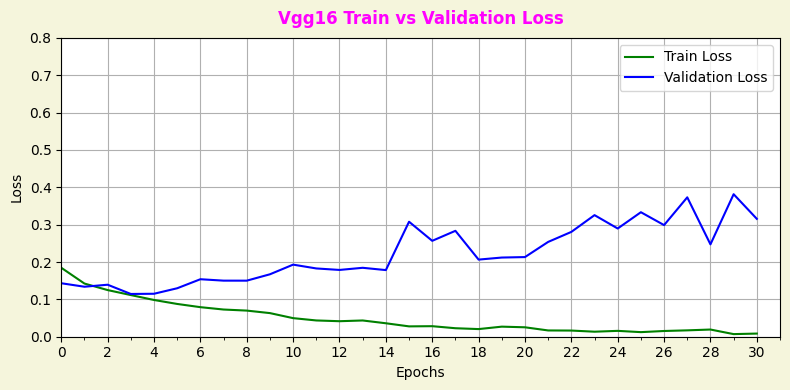

In [26]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
train_loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

plot_results([train_acc, val_acc],
            ["Train Accuracy", "Validation Accuracy"],
             ylabel='Accuracy', ylim=[0.5, 1.0],
             xlim=[0, 31], title='Vgg16 Train vs Validation Accuracy', 
             color=['g', 'b'])

plot_results([train_loss, val_loss],
            ["Train Loss", "Validation Loss"],
             ylabel='Loss', ylim=[0, 0.8],
             xlim=[0, 31], title='Vgg16 Train vs Validation Loss', 
             color=['g', 'b'])

- Adding early stopping to mitigate overfitting.

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
history = model_vgg.fit(train_ds, 
                        epochs=TrainConfig.EPOCHS,
                        validation_data=valid_ds,
                        callbacks=[early_stopping])

Epoch 1/31


I0000 00:00:1715559195.668105    1350 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715559195.692012    1350 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


371/689 ━━━━━━━━━━━━━━━━━━━━ 1:03 200ms/step - accuracy: 0.8869 - loss: 0.2875

W0000 00:00:1715559312.404531    1350 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9087 - loss: 0.2437

W0000 00:00:1715559377.133234    1352 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715559394.442640    1350 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


689/689 ━━━━━━━━━━━━━━━━━━━━ 269s 289ms/step - accuracy: 0.9088 - loss: 0.2436 - val_accuracy: 0.9499 - val_loss: 0.1462
Epoch 2/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 217ms/step - accuracy: 0.9519 - loss: 0.1448 - val_accuracy: 0.9496 - val_loss: 0.1427
Epoch 3/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9607 - loss: 0.1220 - val_accuracy: 0.9536 - val_loss: 0.1497
Epoch 4/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9605 - loss: 0.1170 - val_accuracy: 0.9579 - val_loss: 0.1184
Epoch 5/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9653 - loss: 0.0982 - val_accuracy: 0.9586 - val_loss: 0.1332
Epoch 6/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9680 - loss: 0.0894 - val_accuracy: 0.9612 - val_loss: 0.1155
Epoch 7/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9728 - loss: 0.0793 - val_accuracy: 0.9612 - val_loss: 0.1401
Epoch 8/31
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 216ms/step - accuracy: 0.9768 - loss: 0.06

Saving figure Vgg16 Train vs Validation Accuracy


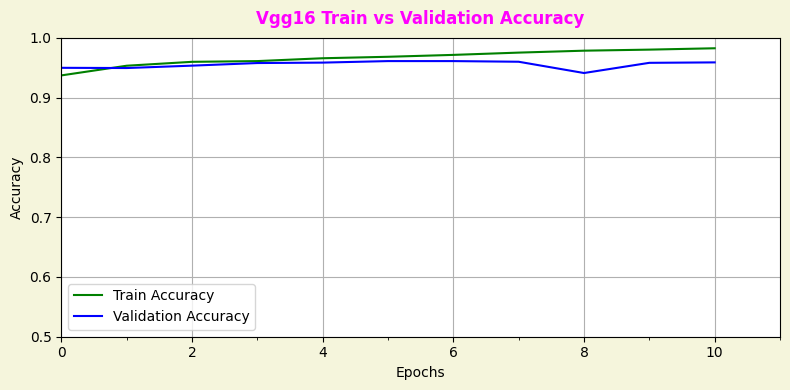

Saving figure Vgg16 Train vs Validation Loss


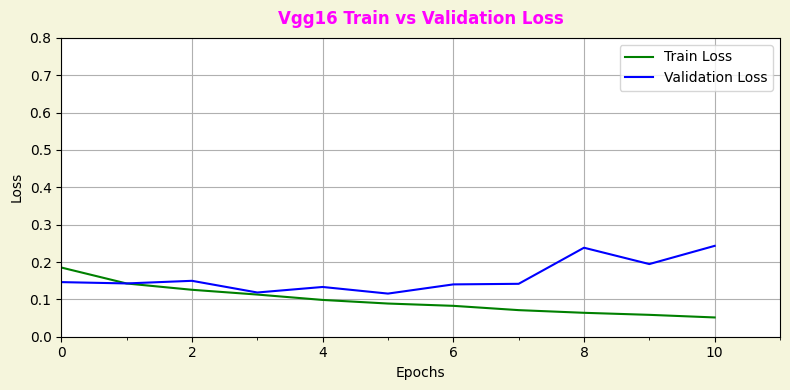

In [18]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plot_results([train_acc, val_acc],
            ["Train Accuracy", "Validation Accuracy"],
             ylabel='Accuracy', ylim=[0.5, 1.0],
             xlim=[0, 11], title='Vgg16 Train vs Validation Accuracy', 
             color=['g', 'b'])

plot_results([train_loss, val_loss],
            ["Train Loss", "Validation Loss"],
             ylabel='Loss', ylim=[0, 0.8],
             xlim=[0, 11], title='Vgg16 Train vs Validation Loss', 
             color=['g', 'b'])

### Model Evaluation.

- With validation dataset.

In [19]:
evaluation = model_vgg.evaluate(valid_ds)
print(f"Prediction accuracy: {evaluation[1] * 100:.3f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9656 - loss: 0.1062
Prediction accuracy: 96.118


- With test dataset.

In [20]:
evaluation = model_vgg.evaluate(test_ds)
print(f"Prediction accuracy: {evaluation[1] * 100:.3f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9656 - loss: 0.1062
Prediction accuracy: 96.118


### Sample Predictions.

In [64]:
def display_predictions(dataset, model, class_names, fig_name):
    plt.figure(figsize=(10, 10))
    num_rows = 4
    num_cols = 5
    jdx = 0

    for image_batch, labels_batch in dataset.take(1):
        print(image_batch.shape)

        predictions = model.predict(image_batch)

        for idx in range(len(labels_batch)):
            pred_idx = int(tf.round(predictions[idx]).numpy())
            truth_idx = int(labels_batch[idx].numpy())

            if pred_idx == truth_idx:
                color = "g"
            else:
                color = "r"

            jdx += 1

            if jdx > num_rows * num_cols:
                break
            
            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])

            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx])
    save_fig(fig_name)
    return

- From the test dataset.

(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Saving figure test_validate


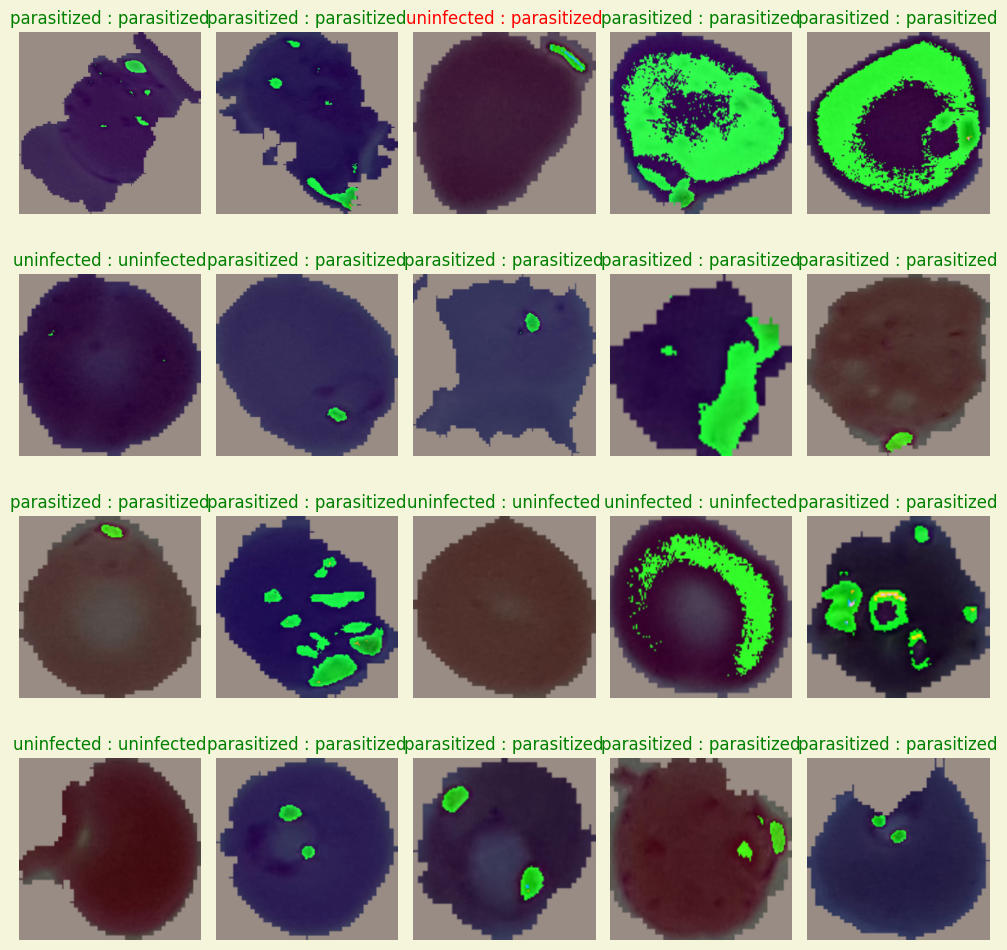

In [65]:
display_predictions(test_ds, model_vgg, info.features['label'].names, "test_validate")

In [66]:
save_model(model_vgg, "fine_tuned_vgg.h5")

Model with that name already exists.
